In [48]:
import pandas as pd
from pathlib import Path

In [66]:
DATA = Path("data")
MODELS = Path("models")
train_path = DATA / "green_tripdata_2024-01.parquet"
validation_path = DATA / "green_tripdata_2024-02.parquet"

In [59]:
def load_dataset(path: Path) -> tuple[pd.DataFrame, pd.Series]:
    df = pd.read_parquet(path)
    df["duration"] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60
    df['pickup_location'] = df.PULocationID.astype('string')
    df['dropoff_location'] = df.DOLocationID.astype('string')

    categoricals = ["pickup_location", "dropoff_location"]
    numericals = ["trip_distance"]
    target = "duration"
    outlier_high = df[target].quantile(0.995)
    n_before = df.shape[0]
    df = df[(df[target] < outlier_high)]
    n_after = df.shape[0]

    print(f"Removed {(n_before - n_after) / n_before * 100:.3f}% outliers at threshold {outlier_high}")

    x = df[categoricals + numericals]
    y = df[target]

    return x, y

In [60]:
train_x, train_y = load_dataset(train_path)
val_x, val_y = load_dataset(validation_path)

Removed 0.500% outliers at threshold 94.2875
Removed 0.500% outliers at threshold 108.1053333333338


In [61]:
from sklearn.feature_extraction import DictVectorizer

In [62]:
dv = DictVectorizer()
x = dv.fit_transform(train_x.to_dict(orient="records"))

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(x, train_y)
y_pred = lr.predict(x)

mean_absolute_error(train_y, y_pred)

np.float64(5.254042755539002)

<Axes: >

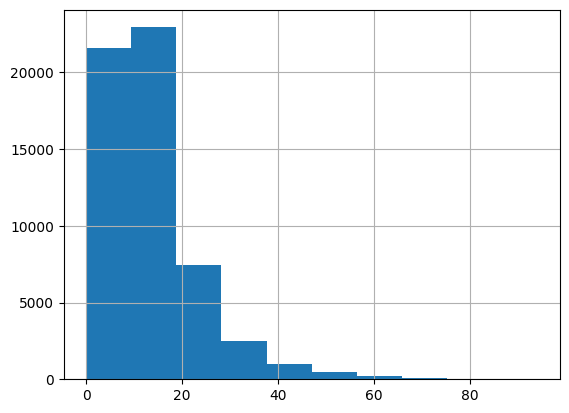

In [64]:
train_y.hist()

In [67]:
import pickle

with open("model.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)
